In [1]:
%matplotlib inline

In [2]:
import numpy as np
from nighres import io
import pandas as pd
import gdist
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import stats
from graphs import subcluster_graph, graph_from_mesh

In [3]:
df = pd.read_csv('/home/julia/data/gradients/results/regions/finest_regions.csv')

In [4]:
mesh = io.load_mesh('/home/julia/data/gradients/atlas/allen_api/regions/annot_finest.vtk')
cortex = np.where(mesh['data']!=0)[0]

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2444: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2447: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


### Make surface masks of the primary areas

In [7]:
for a in ['AUDp', 'VISp', 'MOp']:
    idx = df.loc[df['acronym'] == a, 'id'].values[0]
    new_mesh = {'points':mesh['points'], 'faces':mesh['faces']}
    new_data = np.zeros_like(mesh['data'])
    new_data[np.round(mesh['data'])==idx] = 1
    new_mesh['data']=new_data
    io.save_mesh('/home/julia/data/gradients/results/distance/%s.vtk'%a, new_mesh)

In [8]:
new_mesh = {'points':mesh['points'], 'faces':mesh['faces']}
new_data = np.zeros_like(mesh['data'])

for a in ['SSp-n','SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-ul', 'SSp-tr', 'SSp-un']:
    idx = df.loc[df['acronym'] == a, 'id'].values[0]
    new_data[np.round(mesh['data'])==idx] = 1
    
new_mesh['data']=new_data
io.save_mesh('/home/julia/data/gradients/results/distance/SSp.vtk', new_mesh)

### Calculate distance within cortex from each primary area

In [6]:
for a in ['AUDp', 'VISp', 'MOp']:
    idx = df.loc[df['acronym'] == a, 'id'].values[0]
    source = np.where(np.round(mesh['data'])==idx)[0]
    dist = gdist.compute_gdist(np.array(mesh['points'], dtype=np.float64), 
                               np.array(mesh['faces'], dtype=np.int32), 
                               source_indices=np.array(source, dtype=np.int32),
                               target_indices=np.array(cortex, dtype=np.int32))
    dist[dist==np.inf] = 0
    dist_mesh = np.zeros_like(mesh['data'])
    dist_mesh[cortex] = dist[:,np.newaxis]
    io.save_mesh('/home/julia/data/gradients/results/distance/%s_dist.vtk' %a, 
             {'points':mesh['points'], 'faces':mesh['faces'], 'data':dist_mesh})

In [7]:
l=[]
for a in ['SSp-n','SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-ul', 'SSp-tr', 'SSp-un']:
    idx = df.loc[df['acronym'] == a, 'id'].values[0]
    l.append(list(np.where(np.round(mesh['data'])==idx)[0]))
source = [item for sublist in l for item in sublist]

dist = gdist.compute_gdist(np.array(mesh['points'], dtype=np.float64), 
                           np.array(mesh['faces'], dtype=np.int32), 
                           source_indices=np.array(source, dtype=np.int32),
                           target_indices=np.array(cortex, dtype=np.int32))
dist[dist==np.inf] = 0
dist_mesh = np.zeros_like(mesh['data'])
dist_mesh[cortex] = dist[:,np.newaxis]
io.save_mesh('/home/julia/data/gradients/results/distance/SSp_dist.vtk',
             {'points':mesh['points'], 'faces':mesh['faces'], 'data':dist_mesh})

### Plot distance against gradients

In [8]:
gradients = io.load_mesh('/home/julia/data/gradients/results/embedding_vol/embed_sampled_mesh.vtk')

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2444: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2447: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


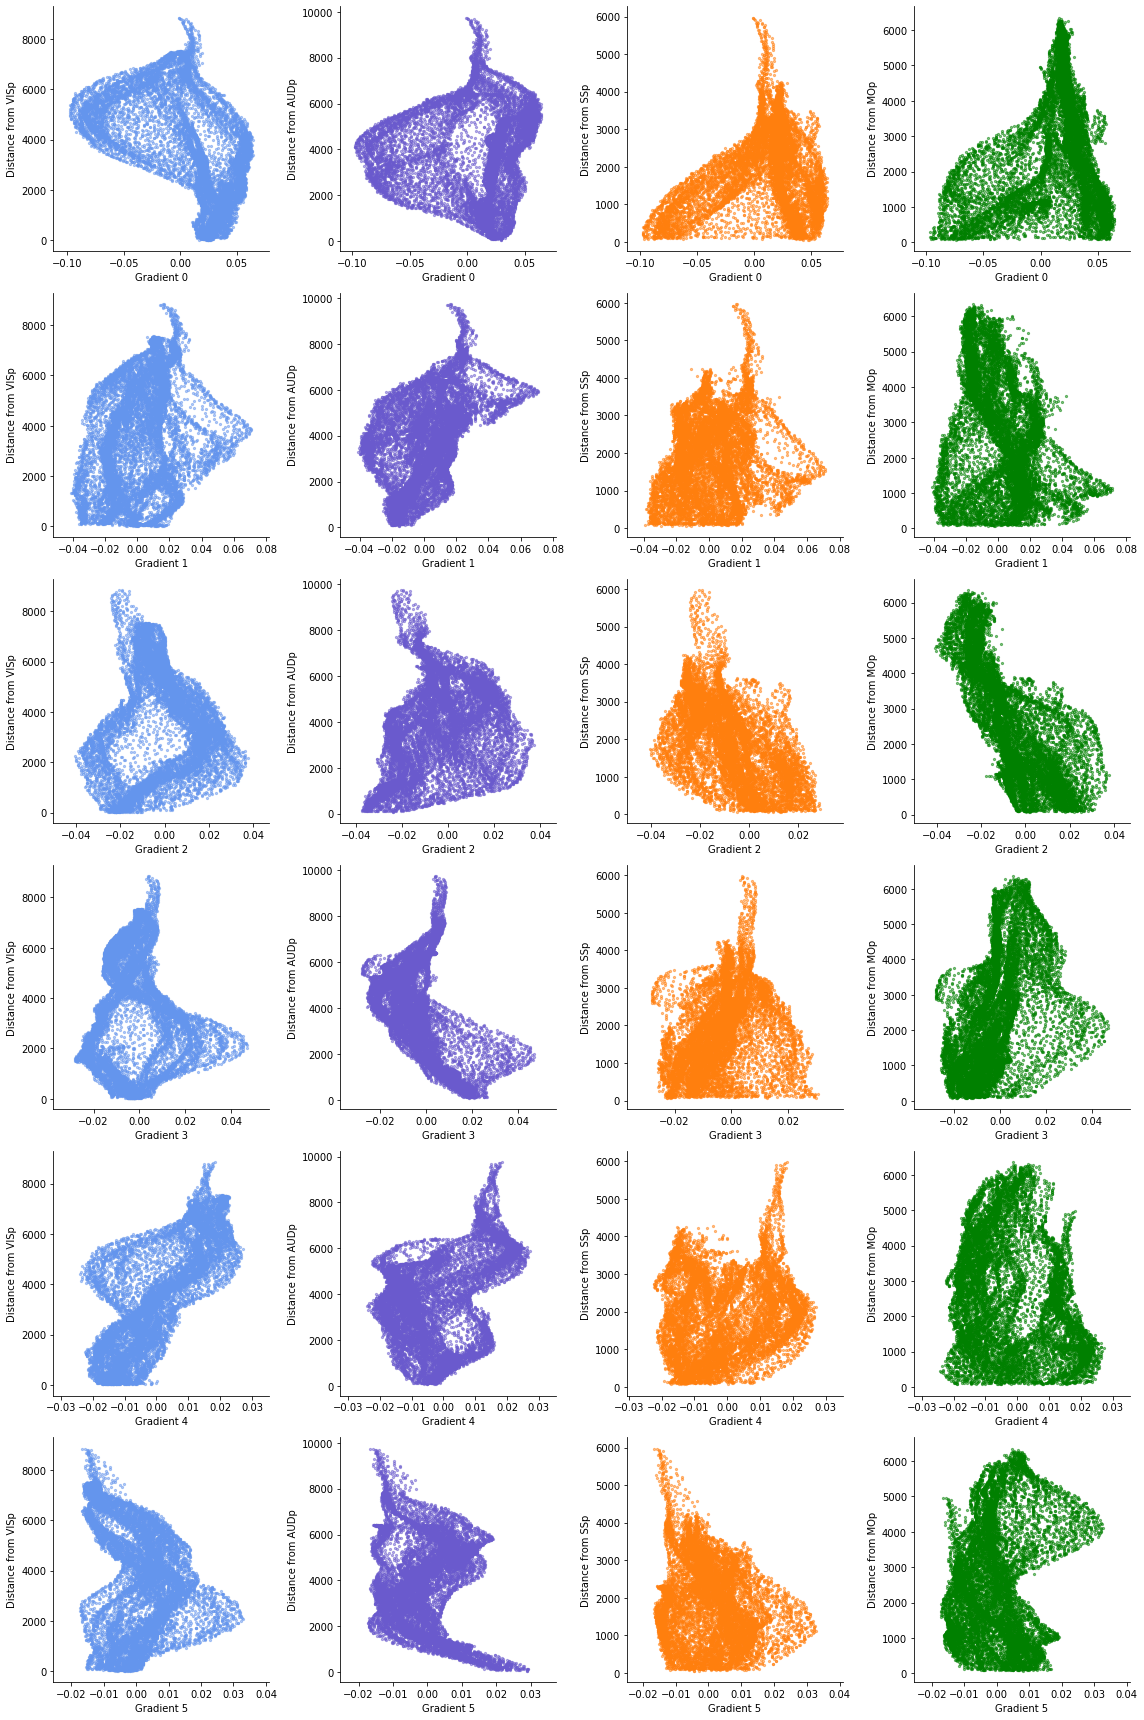

In [10]:
areas = ['VISp', 'AUDp', "SSp", "MOp"]
colors = ['cornflowerblue', 'slateblue', "tab:orange", "green"]
fig = plt.figure(figsize=(16,24))

for g in range(6):
    for a in range(4):
        fig.add_subplot(6,4,(a+1)+(4*g))
        dist = io.load_mesh('/home/julia/data/gradients/results/distance/%s_dist.vtk'%areas[a])
        mask = np.zeros(dist['data'].shape[0], dtype=np.int16)
        mask[gradients['data'][:,g]!=0]=1
        mask[dist['data'][:,0]==0]=0
        mask=np.where(mask==1)[0]
        plt.scatter(gradients['data'][:,g][mask], dist['data'][:,0][mask], alpha=0.5, s=5, color=colors[a])
        plt.xlabel('Gradient %s'%g)
        plt.ylabel('Distance from %s'%areas[a])
        sns.despine()
        plt.tight_layout()

In [11]:
for g in range(6):
    for a in range(4):
        dist = io.load_mesh('/home/julia/data/gradients/results/distance/%s_dist.vtk'%areas[a])
        mask = np.zeros(dist['data'].shape[0], dtype=np.int16)
        mask[gradients['data'][:,g]!=0]=1
        mask[dist['data'][:,0]==0]=0
        mask=np.where(mask==1)[0]
        r = stats.spearmanr(gradients['data'][:,g][mask], dist['data'][:,0][mask])
        if np.abs(r[0]) > 0.5:
            print('Gradient %s' %g, 'Distance from %s' %areas[a], r)

Gradient 0 Distance from VISp SpearmanrResult(correlation=-0.5894860792845721, pvalue=0.0)
Gradient 1 Distance from AUDp SpearmanrResult(correlation=0.526086068065563, pvalue=0.0)
Gradient 2 Distance from SSp SpearmanrResult(correlation=-0.5556241049833168, pvalue=0.0)
Gradient 2 Distance from MOp SpearmanrResult(correlation=-0.8007025526689266, pvalue=0.0)
Gradient 3 Distance from MOp SpearmanrResult(correlation=0.5313977097887052, pvalue=0.0)
Gradient 4 Distance from VISp SpearmanrResult(correlation=0.7466820520702763, pvalue=0.0)


### Distance from type 4 regions

In [12]:
l=[]
for a in ['VISp', 'AUDp', 'SSp-bfd', 'SSp-m']:
    idx = df.loc[df['acronym'] == a, 'id'].values[0]
    l.append(list(np.where(np.round(mesh['data'])==idx)[0]))
source = [item for sublist in l for item in sublist]

dist = gdist.compute_gdist(np.array(mesh['points'], dtype=np.float64), 
                           np.array(mesh['faces'], dtype=np.int32), 
                           source_indices=np.array(source, dtype=np.int32),
                           target_indices=np.array(cortex, dtype=np.int32))
dist[dist==np.inf] = 0
dist_mesh = np.zeros_like(mesh['data'])
dist_mesh[cortex] = dist[:,np.newaxis]
io.save_mesh('/home/julia/data/gradients/results/distance/type4_dist.vtk',
             {'points':mesh['points'], 'faces':mesh['faces'], 'data':dist_mesh})

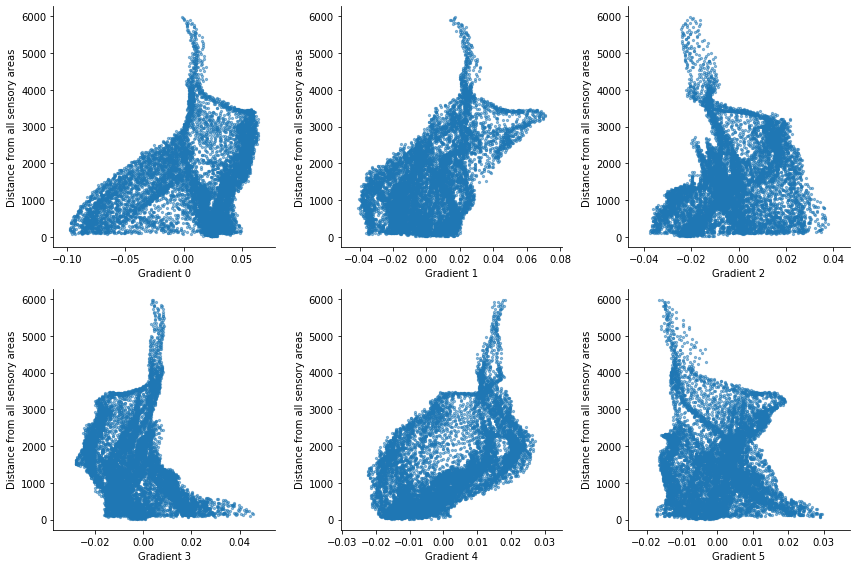

In [13]:
dist = io.load_mesh('/home/julia/data/gradients/results/distance/type4_dist.vtk')

fig = plt.figure(figsize=(12, 8))
for g in range(6):
    fig.add_subplot(2,3,(g+1))
    mask = np.zeros(dist['data'].shape[0], dtype=np.int16)
    mask[gradients['data'][:,g]!=0]=1
    mask[dist['data'][:,0]==0]=0
    mask=np.where(mask==1)[0]
    plt.scatter(gradients['data'][:,g][mask], dist['data'][:,0][mask], alpha=0.5, s=5)
    plt.xlabel('Gradient %s'%g)
    plt.ylabel('Distance from all sensory areas')
    sns.despine()
    plt.tight_layout()

In [14]:
for g in range(6):
    dist = io.load_mesh('/home/julia/data/gradients/results/distance/type4_dist.vtk')
    mask = np.zeros(dist['data'].shape[0], dtype=np.int16)
    mask[gradients['data'][:,g]!=0]=1
    mask[dist['data'][:,0]==0]=0
    mask=np.where(mask==1)[0]
    r = stats.spearmanr(gradients['data'][:,g][mask], dist['data'][:,0][mask])
    if np.abs(r[0]) > 0.5:
        print('Gradient %s' %g, 'Distance from Type 4', r)

Gradient 4 Distance from Type 4 SpearmanrResult(correlation=0.547168719860866, pvalue=0.0)


### Calculate center of mass of primary regions to cover more of cortex

In [41]:
center_data = np.zeros_like(mesh['data'])
for a in ['VISp', 'AUDp', 'SSp-bfd', 'SSp-m']:
    idx = df.loc[df['acronym'] == a, 'id'].values[0]
    patches = np.zeros_like(mesh['data'])
    patches[np.round(mesh['data'])==idx] = 1
    sub_patches = subcluster_graph(mesh['points'],  mesh['faces'], patches)
    patch_a = np.where([sub_patches[:,1]==1])[1]
    patch_b = np.where([sub_patches[:,1]==2])[1]

    for patch in [patch_a, patch_b]:
        x = mesh['points'][patch][:,0].min() + ((mesh['points'][patch][:,0].max() - mesh['points'][patch][:,0].min())/2)
        y = mesh['points'][patch][:,1].min() + ((mesh['points'][patch][:,1].max() - mesh['points'][patch][:,1].min())/2)
        z = mesh['points'][patch][:,2].min() + ((mesh['points'][patch][:,2].max() - mesh['points'][patch][:,2].min())/2)
        center = np.argmin(np.sqrt(np.sum((mesh['points']-[x,y,z])**2, axis=1)))
        center_data[center] = 1

io.save_mesh('/home/julia/data/gradients/results/distance/type4_centers.vtk',
             {'points':mesh['points'], 'faces':mesh['faces'], 'data':center_data})

In [42]:
center_data = io.load_mesh('/home/julia/data/gradients/results/distance/type4_centers.vtk')['data']

In [44]:
source = np.where(center_data==1)[0]
dist = gdist.compute_gdist(np.array(mesh['points'], dtype=np.float64), 
                           np.array(mesh['faces'], dtype=np.int32), 
                           source_indices=np.array(source, dtype=np.int32),
                           target_indices=np.array(cortex, dtype=np.int32))
dist[dist==np.inf] = 0
dist_mesh = np.zeros_like(mesh['data'])
dist_mesh[cortex] = dist[:,np.newaxis]
io.save_mesh('/home/julia/data/gradients/results/distance/type4_center_dist.vtk',
             {'points':mesh['points'], 'faces':mesh['faces'], 'data':dist_mesh})

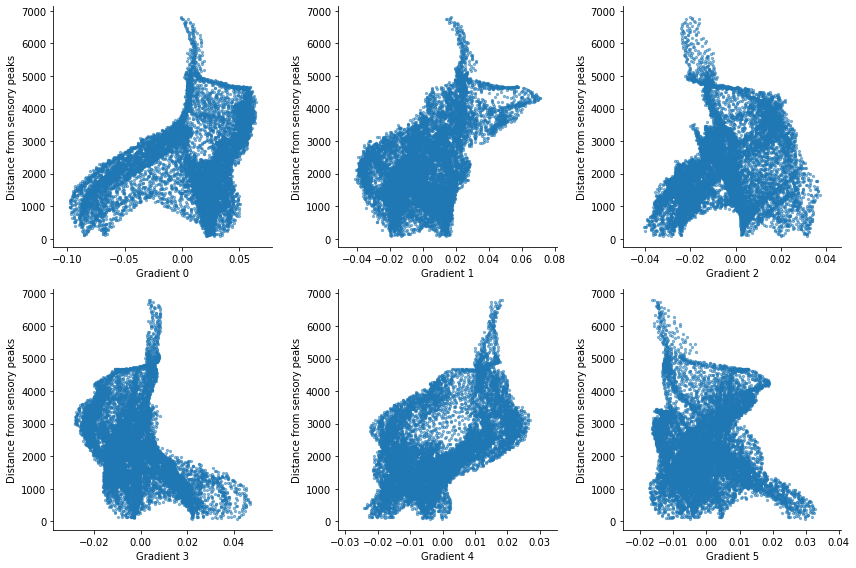

In [46]:
dist = io.load_mesh('/home/julia/data/gradients/results/distance/type4_center_dist.vtk')

fig = plt.figure(figsize=(12, 8))
for g in range(6):
    fig.add_subplot(2,3,(g+1))
    mask = np.zeros(dist['data'].shape[0], dtype=np.int16)
    mask[gradients['data'][:,g]!=0]=1
    mask[dist['data'][:,0]==0]=0
    mask=np.where(mask==1)[0]
    plt.scatter(gradients['data'][:,g][mask], dist['data'][:,0][mask], alpha=0.5, s=5)
    plt.xlabel('Gradient %s'%g)
    plt.ylabel('Distance from sensory peaks')
    sns.despine()
    plt.tight_layout()

In [47]:
dist = io.load_mesh('/home/julia/data/gradients/results/distance/type4_center_dist.vtk')
for g in range(6):
    mask = np.zeros(dist['data'].shape[0], dtype=np.int16)
    mask[gradients['data'][:,g]!=0]=1
    mask[dist['data'][:,0]==0]=0
    mask=np.where(mask==1)[0]
    r = stats.spearmanr(gradients['data'][:,g][mask], dist['data'][:,0][mask])
    if np.abs(r[0]) > 0.5:
        print('Gradient %s' %g, 'Distance from sensory peaks', r)

Gradient 4 Distance from sensory peaks SpearmanrResult(correlation=0.5272874550350521, pvalue=0.0)


### Combine somatosensory regions

In [81]:
patches = np.zeros_like(mesh['data'])
for a in ['SSp-bfd', 'SSp-m']:
    idx = df.loc[df['acronym'] == a, 'id'].values[0]
    patches[np.round(mesh['data'])==idx] = 1
sub_patches = subcluster_graph(mesh['points'],  mesh['faces'], patches)
patch_a = np.hstack((np.where([sub_patches[:,1]==1])[1], np.where([sub_patches[:,1]==2])[1]))
patch_b = np.hstack((np.where([sub_patches[:,1]==3])[1], np.where([sub_patches[:,1]==4])[1]))

for patch in [patch_a, patch_b]:
    x = mesh['points'][patch][:,0].min() + ((mesh['points'][patch][:,0].max() - mesh['points'][patch][:,0].min())/2)
    y = mesh['points'][patch][:,1].min() + ((mesh['points'][patch][:,1].max() - mesh['points'][patch][:,1].min())/2)
    z = mesh['points'][patch][:,2].min() + ((mesh['points'][patch][:,2].max() - mesh['points'][patch][:,2].min())/2)
    center = np.argmin(np.sqrt(np.sum((mesh['points']-[x,y,z])**2, axis=1)))
    center_data[center] = 1

for a in ['VISp', 'AUDp']:
    idx = df.loc[df['acronym'] == a, 'id'].values[0]
    patches = np.zeros_like(mesh['data'])
    patches[np.round(mesh['data'])==idx] = 1
    sub_patches = subcluster_graph(mesh['points'],  mesh['faces'], patches)
    patch_a = np.where([sub_patches[:,1]==1])[1]
    patch_b = np.where([sub_patches[:,1]==2])[1]

    for patch in [patch_a, patch_b]:
        x = mesh['points'][patch][:,0].min() + ((mesh['points'][patch][:,0].max() - mesh['points'][patch][:,0].min())/2)
        y = mesh['points'][patch][:,1].min() + ((mesh['points'][patch][:,1].max() - mesh['points'][patch][:,1].min())/2)
        z = mesh['points'][patch][:,2].min() + ((mesh['points'][patch][:,2].max() - mesh['points'][patch][:,2].min())/2)
        center = np.argmin(np.sqrt(np.sum((mesh['points']-[x,y,z])**2, axis=1)))
        center_data[center] = 1

io.save_mesh('/home/julia/data/gradients/results/distance/type4_centers_b.vtk',
             {'points':mesh['points'], 'faces':mesh['faces'], 'data':center_data})

In [84]:
center_data = io.load_mesh('/home/julia/data/gradients/results/distance/type4_centers_b.vtk')['data']

In [85]:
source = np.where(center_data==1)[0]
dist = gdist.compute_gdist(np.array(mesh['points'], dtype=np.float64), 
                           np.array(mesh['faces'], dtype=np.int32), 
                           source_indices=np.array(source, dtype=np.int32),
                           target_indices=np.array(cortex, dtype=np.int32))
dist[dist==np.inf] = 0
dist_mesh = np.zeros_like(mesh['data'])
dist_mesh[cortex] = dist[:,np.newaxis]
io.save_mesh('/home/julia/data/gradients/results/distance/type4_center_dist_b.vtk',
             {'points':mesh['points'], 'faces':mesh['faces'], 'data':dist_mesh})

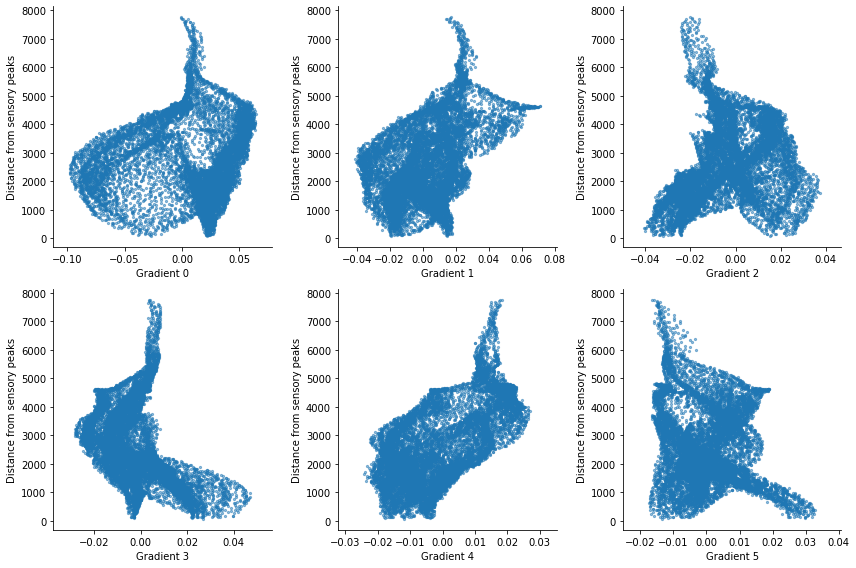

In [86]:
dist = io.load_mesh('/home/julia/data/gradients/results/distance/type4_center_dist_b.vtk')

fig = plt.figure(figsize=(12, 8))
for g in range(6):
    fig.add_subplot(2,3,(g+1))
    mask = np.zeros(dist['data'].shape[0], dtype=np.int16)
    mask[gradients['data'][:,g]!=0]=1
    mask[dist['data'][:,0]==0]=0
    mask=np.where(mask==1)[0]
    plt.scatter(gradients['data'][:,g][mask], dist['data'][:,0][mask], alpha=0.5, s=5)
    plt.xlabel('Gradient %s'%g)
    plt.ylabel('Distance from sensory peaks')
    sns.despine()
    plt.tight_layout()

In [87]:
dist = io.load_mesh('/home/julia/data/gradients/results/distance/type4_center_dist_b.vtk')
for g in range(6):
    mask = np.zeros(dist['data'].shape[0], dtype=np.int16)
    mask[gradients['data'][:,g]!=0]=1
    mask[dist['data'][:,0]==0]=0
    mask=np.where(mask==1)[0]
    r = stats.spearmanr(gradients['data'][:,g][mask], dist['data'][:,0][mask])
    if np.abs(r[0]) > 0.5:
        print('Gradient %s' %g, 'Distance from sensory peaks', r)

Gradient 4 Distance from sensory peaks SpearmanrResult(correlation=0.5972850581415825, pvalue=0.0)


### Distance from single peaks

In [5]:
center_data = np.zeros_like(mesh['data'])
patches = np.zeros_like(mesh['data'])
for a in ['SSp-bfd', 'SSp-m']:
    idx = df.loc[df['acronym'] == a, 'id'].values[0]
    patches[np.round(mesh['data'])==idx] = 1
sub_patches = subcluster_graph(mesh['points'],  mesh['faces'], patches)
patch_a = np.hstack((np.where([sub_patches[:,1]==1])[1], np.where([sub_patches[:,1]==2])[1]))
patch_b = np.hstack((np.where([sub_patches[:,1]==3])[1], np.where([sub_patches[:,1]==4])[1]))

for patch in [patch_a, patch_b]:
    x = mesh['points'][patch][:,0].min() + ((mesh['points'][patch][:,0].max() - mesh['points'][patch][:,0].min())/2)
    y = mesh['points'][patch][:,1].min() + ((mesh['points'][patch][:,1].max() - mesh['points'][patch][:,1].min())/2)
    z = mesh['points'][patch][:,2].min() + ((mesh['points'][patch][:,2].max() - mesh['points'][patch][:,2].min())/2)
    center = np.argmin(np.sqrt(np.sum((mesh['points']-[x,y,z])**2, axis=1)))
    center_data[center] = 1

    io.save_mesh('/home/julia/data/gradients/results/distance/SSp_centers.vtk',
             {'points':mesh['points'], 'faces':mesh['faces'], 'data':center_data})

In [7]:
for a in ['VISp', 'AUDp', 'MOp']:
    center_data = np.zeros_like(mesh['data'])
    idx = df.loc[df['acronym'] == a, 'id'].values[0]
    patches = np.zeros_like(mesh['data'])
    patches[np.round(mesh['data'])==idx] = 1
    sub_patches = subcluster_graph(mesh['points'],  mesh['faces'], patches)
    patch_a = np.where([sub_patches[:,1]==1])[1]
    patch_b = np.where([sub_patches[:,1]==2])[1]

    for patch in [patch_a, patch_b]:
        x = mesh['points'][patch][:,0].min() + ((mesh['points'][patch][:,0].max() - mesh['points'][patch][:,0].min())/2)
        y = mesh['points'][patch][:,1].min() + ((mesh['points'][patch][:,1].max() - mesh['points'][patch][:,1].min())/2)
        z = mesh['points'][patch][:,2].min() + ((mesh['points'][patch][:,2].max() - mesh['points'][patch][:,2].min())/2)
        center = np.argmin(np.sqrt(np.sum((mesh['points']-[x,y,z])**2, axis=1)))
        center_data[center] = 1

    io.save_mesh('/home/julia/data/gradients/results/distance/%s_centers.vtk' %a,
                 {'points':mesh['points'], 'faces':mesh['faces'], 'data':center_data})

In [9]:
areas = ['VISp', 'AUDp', "SSp", "MOp"]
for a in areas:
    center_data = io.load_mesh('/home/julia/data/gradients/results/distance/%s_centers.vtk' %a)['data']
    source = np.where(center_data==1)[0]
    dist = gdist.compute_gdist(np.array(mesh['points'], dtype=np.float64), 
                               np.array(mesh['faces'], dtype=np.int32), 
                               source_indices=np.array(source, dtype=np.int32),
                               target_indices=np.array(cortex, dtype=np.int32))
    dist[dist==np.inf] = 0
    dist_mesh = np.zeros_like(mesh['data'])
    dist_mesh[cortex] = dist[:,np.newaxis]
    io.save_mesh('/home/julia/data/gradients/results/distance/%s_center_dist.vtk'%a,
                 {'points':mesh['points'], 'faces':mesh['faces'], 'data':dist_mesh})

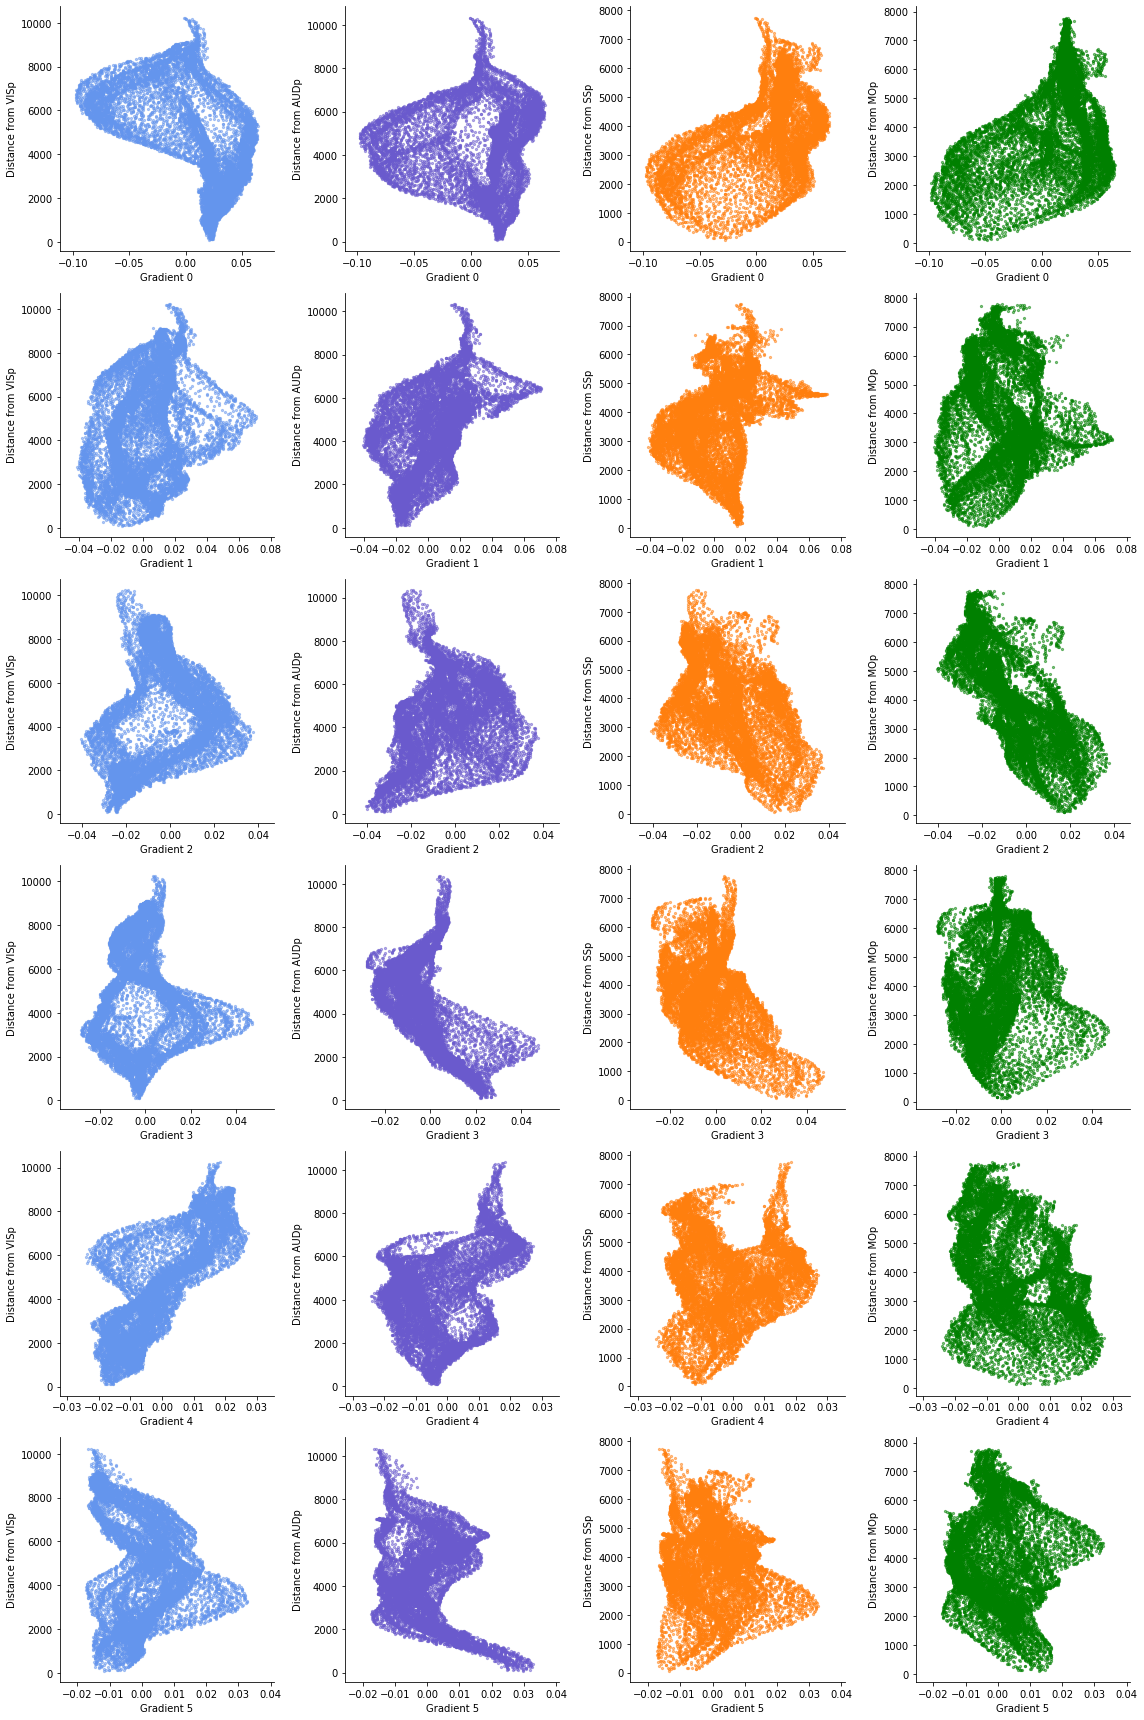

In [10]:
areas = ['VISp', 'AUDp', "SSp", "MOp"]
colors = ['cornflowerblue', 'slateblue', "tab:orange", "green"]
fig = plt.figure(figsize=(16,24))

for g in range(6):
    for a in range(4):
        fig.add_subplot(6,4,(a+1)+(4*g))
        dist = io.load_mesh('/home/julia/data/gradients/results/distance/%s_center_dist.vtk'%areas[a])
        mask = np.zeros(dist['data'].shape[0], dtype=np.int16)
        mask[gradients['data'][:,g]!=0]=1
        mask[dist['data'][:,0]==0]=0
        mask=np.where(mask==1)[0]
        plt.scatter(gradients['data'][:,g][mask], dist['data'][:,0][mask], alpha=0.5, s=5, color=colors[a])
        plt.xlabel('Gradient %s'%g)
        plt.ylabel('Distance from %s'%areas[a])
        sns.despine()
        plt.tight_layout()

In [23]:
for g in range(6):
    for a in range(4):
        dist = io.load_mesh('/home/julia/data/gradients/results/distance/%s_center_dist.vtk'%areas[a])
        mask = np.zeros(dist['data'].shape[0], dtype=np.int16)
        mask[gradients['data'][:,g]!=0]=1
        mask[dist['data'][:,0]==0]=0
        mask=np.where(mask==1)[0]
        r = stats.spearmanr(gradients['data'][:,g][mask], dist['data'][:,0][mask])
        if np.abs(r[0]) > 0.2:
            print('Gradient %s' %g, 'Distance from %s' %areas[a], r)

Gradient 0 Distance from VISp SpearmanrResult(correlation=-0.5625050450013218, pvalue=0.0)
Gradient 0 Distance from SSp SpearmanrResult(correlation=0.3611473078119217, pvalue=0.0)
Gradient 0 Distance from MOp SpearmanrResult(correlation=0.2551299765838011, pvalue=2.728673205686258e-171)
Gradient 1 Distance from VISp SpearmanrResult(correlation=0.2864267359232938, pvalue=2.757713951110976e-217)
Gradient 1 Distance from AUDp SpearmanrResult(correlation=0.5407877779715534, pvalue=0.0)
Gradient 1 Distance from SSp SpearmanrResult(correlation=0.37212272205231806, pvalue=0.0)
Gradient 2 Distance from VISp SpearmanrResult(correlation=0.28411892682701234, pvalue=1.1057683647298635e-213)
Gradient 2 Distance from AUDp SpearmanrResult(correlation=0.3106720039151879, pvalue=3.0532221850883362e-257)
Gradient 2 Distance from SSp SpearmanrResult(correlation=-0.41566156654324526, pvalue=0.0)
Gradient 2 Distance from MOp SpearmanrResult(correlation=-0.7690066665678705, pvalue=0.0)
Gradient 3 Distance f

In [21]:
# For plotting
dist = io.load_mesh('/home/julia/data/gradients/results/distance/VISp_center_dist.vtk')['data']
dist[dist!=0]-=np.mean(dist[dist!=0])
io.save_mesh('/home/julia/data/gradients/results/distance/VISp_center_dist_zeromean.vtk',
                 {'points':mesh['points'], 'faces':mesh['faces'], 'data':dist})

In [19]:
# For plotting
dist = io.load_mesh('/home/julia/data/gradients/results/distance/MOp_center_dist.vtk')['data']
dist[dist!=0]-=np.mean(dist[dist!=0])
io.save_mesh('/home/julia/data/gradients/results/distance/MOp_center_dist_zeromean.vtk',
                 {'points':mesh['points'], 'faces':mesh['faces'], 'data':dist})

In [22]:
dist_a = io.load_mesh('/home/julia/data/gradients/results/distance/VISp_center_dist.vtk')['data']
dist_b = io.load_mesh('/home/julia/data/gradients/results/distance/MOp_center_dist.vtk')['data']
mask = np.zeros(dist_a.shape[0], dtype=np.int16)
r = stats.spearmanr(dist_a[cortex], dist_b[cortex])
print(r)

SpearmanrResult(correlation=-0.5774363593238473, pvalue=0.0)


In [29]:
gradient_2 = gradients['data'][:,2]
gradient_4 = gradients['data'][:,4]
r = stats.spearmanr(gradient_2[cortex], gradient_4[cortex])
print(r)

SpearmanrResult(correlation=0.09629710039803047, pvalue=7.880714113048206e-26)


### Test simple distance along axes

In [37]:
for g in range(6):
    for a in range(3):
        r = stats.spearmanr(gradients['data'][:,g][cortex], mesh['points'][cortex][:,a])
        print('Gradient %s' %g, 'Axis %s' %a, r)

Gradient 0 Axis 0 SpearmanrResult(correlation=0.39825298612087257, pvalue=0.0)
Gradient 0 Axis 1 SpearmanrResult(correlation=-0.7618417068196369, pvalue=0.0)
Gradient 0 Axis 2 SpearmanrResult(correlation=0.00680747096807299, pvalue=0.45859419953456537)
Gradient 1 Axis 0 SpearmanrResult(correlation=-0.2667680806665898, pvalue=2.568768383733895e-192)
Gradient 1 Axis 1 SpearmanrResult(correlation=-0.016498822354997958, pvalue=0.07242910900519443)
Gradient 1 Axis 2 SpearmanrResult(correlation=-0.05718423775145105, pvalue=4.6357688329967007e-10)
Gradient 2 Axis 0 SpearmanrResult(correlation=-0.4869299111675134, pvalue=0.0)
Gradient 2 Axis 1 SpearmanrResult(correlation=-0.2381491813457714, pvalue=1.5706880605160504e-152)
Gradient 2 Axis 2 SpearmanrResult(correlation=0.047148492530618875, pvalue=2.805121048756441e-07)
Gradient 3 Axis 0 SpearmanrResult(correlation=0.11637483193617153, pvalue=4.9830389429719995e-37)
Gradient 3 Axis 1 SpearmanrResult(correlation=0.45568770717340396, pvalue=0.0)


array([7896.56, 7777.44, 7903.  , ..., 7770.58, 7890.6 , 7955.18])